In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read Data and store on dataframes
movie_database = pd.read_csv('Small_Data/movies.csv')
users_ratings = pd.read_csv('Small_Data/ratings.csv')
tags_database = pd.read_csv('Small_Data/tags.csv')
links_database = pd.read_csv('Small_Data/links.csv')

In [3]:
# Display the first 10 items from the movies data set
movie_database[0:5]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Display the first 5 items from the rating data set
users_ratings[0:5]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Shift users and movies ID by 1, so start at 0
users_ratings['userId'] = users_ratings['userId'] - 1
users_ratings['movieId'] = users_ratings['movieId'] - 1
movie_database['movieId'] = movie_database['movieId'] - 1

In [6]:
# Print ratings statistics describing numeric features
users_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,325.127564,19434.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,0.000000,0.000000,0.500000,8.281246e+08
25%,176.000000,1198.000000,3.000000,1.019124e+09
50%,324.000000,2990.000000,3.500000,1.186087e+09
75%,476.000000,8121.000000,4.000000,1.435994e+09
max,609.000000,193608.000000,5.000000,1.537799e+09


In [7]:
'''
Alg:
1. Get userId list list_user
2. Get movieId list list_movie
3. For each user:
    a. Get ratings by user
    b. For each index of ratings in users_ratings dataframe:
        i. Get movieid index (column index) in ratings['movieId']
        ii. Append (user, movie, rating) to output list
4. Returns 3-tuple (output_list, list_user, list_movie)
'''
def get_user_item_pairs():
    list_userId = np.array(pd.unique(users_ratings['userId']))
    list_movieId = np.array(pd.unique(movie_database['movieId']))
    movie_index_list = pd.Index(movie_database['movieId'])
    output_list = []
    # index by user
    for user_index in np.arange(0, len(list_userId)):
        # associated user_id with user
        user_id = list_userId[user_index]
        # ratings by user
        ratings = users_ratings[users_ratings['userId'] == user_id]
        # for each row index associated with user
        for index in ratings.index:
            # get movie id for finding movie index
            movie_id = users_ratings['movieId'].iloc[index]
            # get movie index to place in list
            movie_index = movie_index_list.get_loc(movie_id)#movie_database['movieId'].loc[movie_id]
            # get rating
            rating = users_ratings['rating'].iloc[index]
            #rating = ratings['rating'].loc[index]
            #output_list.append((user_index, movie_index, rating))
            output_list.append([user_index,movie_index,rating])
    
    #output_list = np.array(output_list,dtype='i4,i4,i4')
    data_set = pd.DataFrame(output_list,columns=['user_idx','movie_idx','rating'])
    
    return(data_set,list_userId,list_movieId)
    #return (np.array(output_list, dtype='i4,i4,i4'), list_userId, list_movieId)
#     return (np.array(output_list, dtype=[('user_index', '<i4'), ('movie_index', '<i4'), ('rating', '<i4')]), list_userId, list_movieId)
'''
Input:
    S is a collection of 3-tuples (user, movie, rating)
        user is the index of the user in list_userId
        movie is the index of the movie in list_movieId
        rating is the corresponding rating
    Output: mxn feedback matrix
        m is the length of list_userId
        n is the length of list_movieId
        Entry (i, j) is nonzero if list_userId[i] reviewed list_movieId[j]
'''
def build_feedback_matrix(data_set, list_userId_len, list_movieId_len):
    """
    m = list_userId.shape[0]
    n = list_movieId.shape[0]
    F = np.zeros((m, n))
    for (user_index, movie_index, rating) in S:
        F[user_index, movie_index] = rating
    return F
    """
    feedback_matrix = np.zeros((list_userId_len,list_movieId_len))
    for index in data_set.index:
        user_index = data_set['user_idx'].loc[index]
        movie_index = data_set['movie_idx'].loc[index]
        rating = data_set['rating'].loc[index]
        feedback_matrix[user_index,movie_index] = rating
    
    return feedback_matrix


# Break the dataset into test and train sets
# Keep a 0.1 holdout fraction to construct test
def data_split(data,holdout_fraction=0.1):
    data_copy = data.copy()
    data_copy = data_copy.sample(frac=1)
    test_set = data_copy.sample(frac=holdout_fraction)
    train_set = data_copy[~data_copy.index.isin(test_set.index)]
    return train_set, test_set

In [8]:
# Construct the data set based on the index of user, movies bind with the respective rating
# Build the list of usersIds
# Build the list of movieIds
(user_item_rating, list_userId, list_movieId)  = get_user_item_pairs()

In [9]:
# Objetive function
# Implement Mean Square Error(MSE)
def calculate_loss(feedback_matrix,P,V):
    #Calculate the ratings matrix approximation
    predictions = np.dot(P,V.T)
    
    # Calculate the square error for each reating
    error_matrix = np.square((feedback_matrix - predictions))
    
    # Return the mean square error over the last dimension
    return np.mean(error_matrix)

In [10]:
class CF_Model(object):
    def __init__(self,users,movies):
        self.embedding_vars = {}
        self.train_loss = []
        self.test_loss = []
        self.list_userId = users
        self.list_movieId = movies
        self.num_users = users.shape[0]
        self.num_movies = movies.shape[0]
        self.num_features = 0

    def embeddings(self):
        return self.embedding_vars
    
    def build_model(self,num_features=30,mu=0,std=1):
        """
            m: number of users
            n: number of movies
            k: number of features or latent factors   
            P: m x k: associative matrix btw Users and Features 
            V: n x k: associative matrix btw Movies and Features
        """
        self.num_features = num_features
        P = np.random.normal(loc=mu,scale=std,size=(self.num_users,num_features))
        V = np.random.normal(loc=mu,scale=std,size=(self.num_movies,num_features))
        self.embedding_vars['P'] = P
        self.embedding_vars['V'] = V
    
    def train(self,data_set,num_iter=100,learning_rate=0.00002,regulator=0.02):
        train_data, test_data =  data_split(data_set)
        train_matrix = build_feedback_matrix(train_data,self.num_users,self.num_movies)
        test_matrix = build_feedback_matrix(test_data,self.num_users,self.num_movies)
        P = self.embedding_vars['P']
        V = self.embedding_vars['V'].T

        for epoch in range(num_iter):
            
            for i in range(self.num_users):
                for j in range(self.num_movies):
                    if train_matrix[i,j] > 0:
                        eij = train_matrix[i,j] - np.dot(P[i,:],V[:,j])
                        
                        for k in range(self.num_features):
                            gradient_P = 2 * eij * V[k,j] - regulator * P[i,k]
                            gradient_V = 2 * eij * P[i,k] - regulator * V[k,j]
                            P[i,k] = P[i,k] + learning_rate * gradient_P
                            V[k,j] = V[k,j] + learning_rate * gradient_V
          
            train_error = calculate_loss(train_matrix,P,V.T)
            test_error = calculate_loss(test_matrix,P,V.T)
            print("i: " + str(epoch) + " Train Loss: " + str(train_error) + " - Test Loss: " + str(test_error))
            self.train_loss.append(train_error)
            self.test_loss.append(test_error)
        self.embedding_vars['P'] = P
        self.embedding_vars['V'] = V.T
    
    def plot_loss(self):
        fig = plt.figure()
        fig.suptitle('Loss vs Number of Epochs')
        ax = fig.add_subplot(111)
        x1 = np.arange(len(self.train_loss))
        x2 = np.arange(len(self.test_loss))
        ax.plot(x1, self.train_loss, label='Train Data')
        ax.plot(x2, self.test_loss, label='Test Data')
        ax.set_ylabel('MSE Loss')
        ax.set_xlabel('Epoch Number')
        plt.legend()
        plt.show()
    """
    def compute_scores(self,query_embedding,item_embedding,similarity_mesure='dot'):
        
        #    Similarity Mesure: Dot Product or Cosine
        
        if similarity_mesure == 'dot':
            score = np.dot(query_embedding,item_embedding.T)

        elif similarity_mesure == 'cos':
            query_norm = np.linalg.norm(query_embedding)
            item_norm = np.linalg.norm(item_embedding)
            score = np.dot(query_embedding,item_embedding.T) / (query_norm * item_norm)

        return score
    
    def user_base_rank(self,user_id,list_users_id,num_recomendations):
        user_index = -1 
        user_index = np.where(list_users_id==user_id)
        if user_index ==  -1:
            print("Error: User Id not valid, Not Found")
            return
        
        users_embeddings = model.embedding_vars['P']
        movies_embeddings = model.embedding_vars['V']

        user_embedding = users_embeddings[user_index,:]
        scores = self.compute_scores(user_embedding.T,movies_embeddings.T)


    def movie_base_rank(self,movie_title):
        pass
    """

In [78]:
def compute_scores(model,query_embedding,item_embedding,similarity_mesure='dot'):
    """
    Similarity Mesure: Dot Product or Cosine
    """    
    if similarity_mesure == 'dot':
        score = np.dot(query_embedding,item_embedding.T)

    elif similarity_mesure == 'cos':
        query_norm = np.linalg.norm(query_embedding)
        item_norm = np.linalg.norm(item_embedding)
        score = np.dot(query_embedding,item_embedding.T) / (query_norm * item_norm)

    return score
    
def user_base_rank(model,user_id,list_users_id,list_movies_id,num_recomendations=5):
    user_index = -1 
    user_index = np.where(list_users_id==user_id)
    if user_index ==  -1:
        print("Error: User Id not valid, Not Found")
        return
        
    users_embeddings = model.embedding_vars['P']
    movies_embeddings = model.embedding_vars['V']

    user_embedding = users_embeddings[user_index]
    scores = compute_scores(model,user_embedding,movies_embeddings,similarity_mesure='dot')[-1]
    
    k_top_scores_index = np.argsort(scores)
    k_top_scores = scores[k_top_scores_index[-1*num_recomendations:]]

    k_top_moviesId = list_movies_id[k_top_scores_index]
    
def movie_base_rank(model,movie_title):
    pass

In [79]:
user_base_rank(model,1,list_userId,list_movieId,5)

In [19]:
model = CF_Model(list_userId, list_movieId)

In [20]:
model.build_model(num_features=5)

In [21]:
model.train(user_item_rating,num_iter=20,learning_rate=0.0001)

i: 0 Train Loss: 4.753777579227742 - Test Loss: 4.5733357644303885
i: 1 Train Loss: 4.538183782826703 - Test Loss: 4.3582989356852
i: 2 Train Loss: 4.3558669210229795 - Test Loss: 4.176479978710268
i: 3 Train Loss: 4.198104329666402 - Test Loss: 4.019170750147217
i: 4 Train Loss: 4.059279435730763 - Test Loss: 3.8807646801161293
i: 5 Train Loss: 3.935553688562383 - Test Loss: 3.75743060066717
i: 6 Train Loss: 3.8241785589532853 - Test Loss: 3.6464257284139845
i: 7 Train Loss: 3.723113202333575 - Test Loss: 3.545713884594816
i: 8 Train Loss: 3.6307982011591995 - Test Loss: 3.4537395795366472
i: 9 Train Loss: 3.546014216133331 - Test Loss: 3.3692868894259713
i: 10 Train Loss: 3.467789597030626 - Test Loss: 3.2913872249653586
i: 11 Train Loss: 3.395337716246803 - Test Loss: 3.219256781086268
i: 12 Train Loss: 3.328013159719976 - Test Loss: 3.1522528172727897
i: 13 Train Loss: 3.265280331681371 - Test Loss: 3.0898423340413625
i: 14 Train Loss: 3.2066904860854595 - Test Loss: 3.031579164267

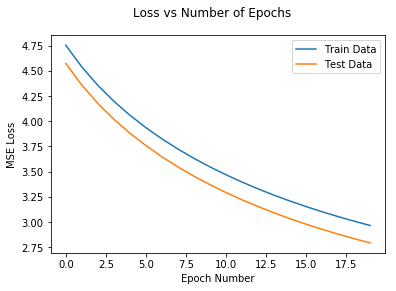

In [22]:
model.plot_loss()